In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
train = pd.read_csv('./mnist_train.csv')
test = pd.read_csv('./mnist_test.csv')
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [3]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
Y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)
X_train /= 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
Y_train = to_categorical(Y_train, num_classes=10)

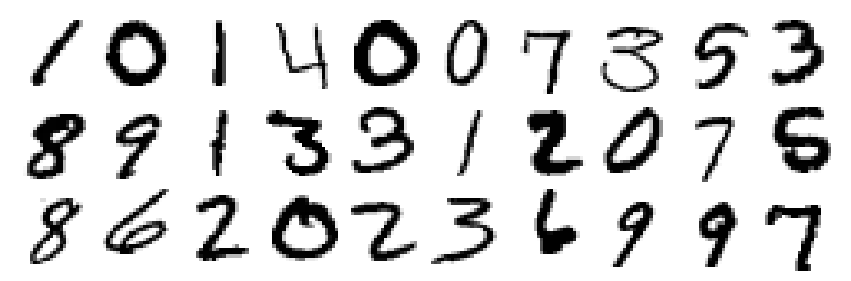

In [6]:
plt.figure(figsize=(15, 5))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [7]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.01,
    width_shift_range=0.1,
    height_shift_range=0.1
)

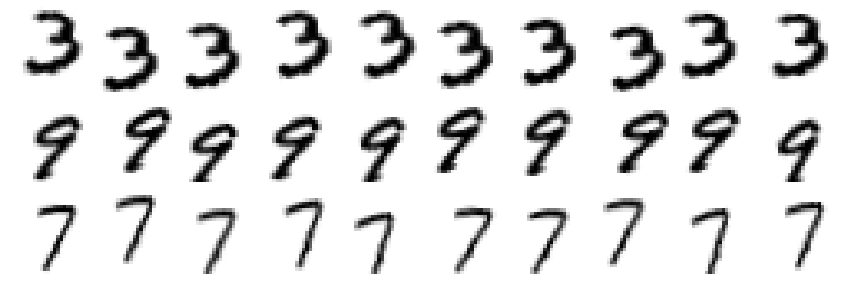

In [8]:
X_train1 = X_train[9,].reshape((1, 28, 28, 1))
Y_train1 = Y_train[9,].reshape((1, 10))
plt.figure(figsize=(15, 5))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    X_train2, Y_train2 = datagen.flow(X_train1, Y_train1).next()
    plt.imshow(X_train2[0].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
    if i == 9:
        X_train1 = X_train[11,].reshape((1, 28, 28, 1))
    if i == 19:
        X_train1 = X_train[18,].reshape((1, 28, 28, 1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [9]:
nets = 15
model = [0] * nets
for i in range(nets):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size=3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(64, kernel_size=3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size=3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(128, kernel_size=4, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Flatten())
    model[i].add(Dropout(0.3))
    model[i].add(Dense(10, activation='softmax'))

    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
history = [0] * nets
epochs = 3

In [10]:
for i in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)
    history[i] = model[i].fit_generator(datagen.flow(X_train2, Y_train2, batch_size=64),
                                        epochs=epochs,
                                        steps_per_epoch=X_train2.shape[0] // 64,
                                        validation_data=(X_val2, Y_val2),
                                        callbacks=[annealer],
                                        verbose=0)
    print('CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}'.format(
        i + 1, epochs, max(history[i].history['accuracy']), max(history[i].history['val_accuracy'])))

results = np.zeros((X_test.shape[0], 10))

C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


CNN 1: Epochs=3, Train accuracy=0.97313, Validation accuracy=0.99095
CNN 2: Epochs=3, Train accuracy=0.97172, Validation accuracy=0.98595
CNN 3: Epochs=3, Train accuracy=0.97546, Validation accuracy=0.98571
CNN 4: Epochs=3, Train accuracy=0.97406, Validation accuracy=0.98952
CNN 5: Epochs=3, Train accuracy=0.97212, Validation accuracy=0.98548
CNN 6: Epochs=3, Train accuracy=0.97350, Validation accuracy=0.98976
CNN 7: Epochs=3, Train accuracy=0.97125, Validation accuracy=0.99048
CNN 8: Epochs=3, Train accuracy=0.97437, Validation accuracy=0.98976
CNN 9: Epochs=3, Train accuracy=0.97424, Validation accuracy=0.98381
CNN 10: Epochs=3, Train accuracy=0.97239, Validation accuracy=0.98786
CNN 11: Epochs=3, Train accuracy=0.97284, Validation accuracy=0.98762
CNN 12: Epochs=3, Train accuracy=0.97276, Validation accuracy=0.98643
CNN 13: Epochs=3, Train accuracy=0.97308, Validation accuracy=0.98976
CNN 14: Epochs=3, Train accuracy=0.97252, Validation accuracy=0.98929
CNN 15: Epochs=3, Train accur

In [11]:
for i in range(nets):
    results = results + model[i].predict(X_test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv('./MNIST_ENSEMBLE.csv', index=False)

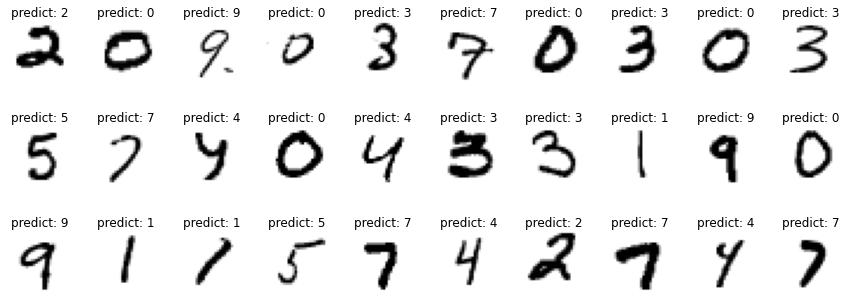

In [12]:
plt.figure(figsize=(15, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_test[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title('predict: {}'.format(results[i]), y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

C:\Users\qwl\AppData\Local\Temp/ipykernel_25300/1664878300.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(history) / 5, 5, i)


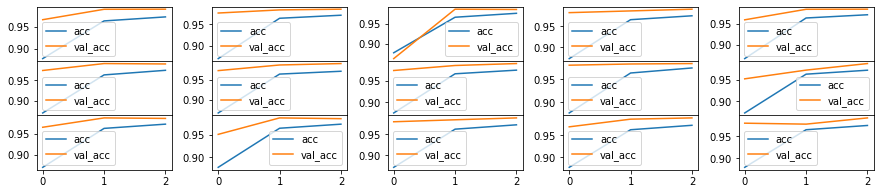

In [13]:
plt.figure(figsize=(15, 3))
for i, h in enumerate(history):
    i += 1
    plt.subplot(len(history) / 5, 5, i)
    plt.plot(h.epoch, h.history.get('accuracy'), label='acc')
    plt.plot(h.epoch, h.history.get('val_accuracy'), label='val_acc')
    plt.legend()
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

C:\Users\qwl\AppData\Local\Temp/ipykernel_25300/3887798875.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(history) / 5, 5, i)


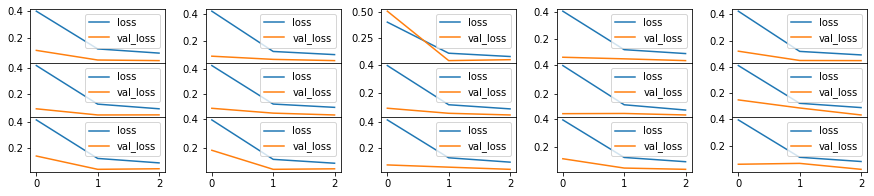

In [14]:
plt.figure(figsize=(15, 3))
for i, h in enumerate(history):
    i += 1
    plt.subplot(len(history) / 5, 5, i)
    plt.plot(h.epoch, h.history.get('loss'), label='loss')
    plt.plot(h.epoch, h.history.get('val_loss'), label='val_loss')
    plt.legend()
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()